# Exercício de Segmentação

Neste exercício iremos segmentar o ventrículo esquerdo do coração em imagens relativamente pequenas usando redes neuronais. 
Apresenta-se o código de criação de uma rede de segmentação e respectivo treino. A rede não é muito boa, por isso **o exercício é melhorar a qualidade da segmentação, melhorando a rede e/ou o esquema de formação, incluindo a eficiência da carga de dados e o aumento de dados**. 

Os dados aqui utilizados são derivados do [Sunnybrook Cardiac Dataset](https://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/) de imagens de RM cardíaca, filtradas para conter apenas segmentações do miocárdio ventricular esquerdo e reduzidas nas dimensões XY.

Primeiro instalamos e importamos MONAI mais outras dependências:

In [1]:
%matplotlib inline

from urllib.request import urlopen
from io import BytesIO

import torch, torch.nn as nn, torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

import monai
from monai.utils import first
from monai.transforms import Transform, Compose, AddChannel, ScaleIntensity, ToTensor
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import ArrayDataset
from torch.utils.data import DataLoader
from monai.utils import progress_bar

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DATA_NPZ = "https://github.com/ericspod/VPHSummerSchool2019/raw/master/scd_lvsegs.npz"
pin_memory=torch.cuda.is_available()

batch_size = 50
num_workers = 2
num_epochs = 200
lr = 5e-3

## 1. Preparação dos dados
Agora carregamos os dados a partir da fonte remota e visualizamos uma amostra:

(420, 64, 64) (420, 64, 64) (45, 2)


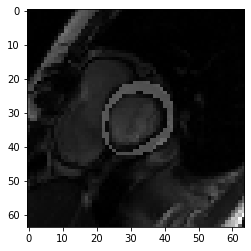

In [2]:
'''
remote_file = urlopen(DATA_NPZ)
npz = BytesIO(remote_file.read())
data = np.load(npz)  # load all the data from the archive
'''
data=np.load('scd_lvsegs.npz')
images = data["images"]  #images in BHW array order
segs = data["segs"]  #segmentations in BHW array order
case_indices = data["caseIndices"]  #the indices in `images` for each case (como é 3D cada caso tem várias imagens)

images = images.astype(np.float32) / images.max()  #normalize images

print(images.shape, segs.shape, case_indices.shape)
plt.imshow(images[13] + (segs[13] * 0.25), cmap="gray")  #show image 13 with segmentation

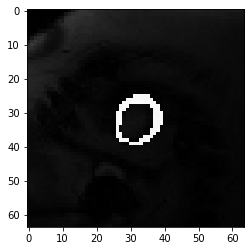

In [3]:
plt.imshow(images[12] + segs[12], cmap="gray")  #show image 13 with segmentation

Dividimos os nossos dados num conjunto de formação e validação, mantendo os últimos 6 casos:

In [4]:
test_index = case_indices[-6, 0]  #keep the last 6 cases for testing

#divide the images, segmentations, and categories into train/test sets
train_images, train_segs = images[:test_index], segs[:test_index]
test_images, test_segs = images[test_index:], segs[test_index:]

Podemos agora criar um objecto de carregamento de dados MONAI para compor lotes durante o treino e outro para validação:

torch.Size([50, 1, 64, 64]) tensor(0.) tensor(1.) torch.Size([50, 1, 64, 64])


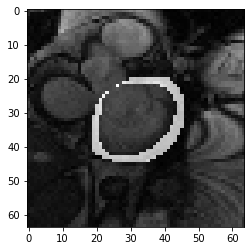

In [10]:
#ScaleIntensity(),  #rescale image data to range [0,1]
#AddChannel(),  #add 1-size channel dimension
#ToTensor(),  #convert to tensor

image_trans = Compose([ScaleIntensity(), AddChannel(), ToTensor()])
seg_trans = Compose([AddChannel(), ToTensor()])

ds = ArrayDataset(train_images, image_trans, train_segs, seg_trans)
loader = DataLoader(dataset=ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

val_ds = ArrayDataset(test_images, image_trans, test_segs, seg_trans)
val_loader = DataLoader(dataset=val_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

im, seg = first(loader)
print(im.shape, im.min(), im.max(), seg.shape)
plt.imshow(im[0, 0].numpy() + seg[0, 0].numpy(), cmap="gray")

## 2. Definir o modelo
Definimos agora uma rede simples. Isto não faz um bom trabalho, por isso considerem como melhorá-la, adicionando camadas ou outros elementos:

In [1]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            #layer 1: convolution, normalization, downsampling
            nn.Conv2d(1, 2, 3, 1, 1),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1),
            #layer 2
            nn.Conv2d(2, 4, 3, 1, 1),
            #layer 3
            nn.ConvTranspose2d(4, 2, 3, 2, 1, 1),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            #layer 4: output
            nn.Conv2d(2, 1, 3, 1, 1),
        )
        
    def forward(self, x):
        return self.model(x)

## 3. Treino do modelo
O treino é muito simples. Para cada época treinamos em cada lote de imagens do conjunto de treino, treinando assim uma vez com cada imagem, e depois avaliamos com o conjunto de validação.

In [8]:
net = SegNet()
net = net.to(device)

opt = torch.optim.Adam(net.parameters(), lr)
loss = DiceLoss(sigmoid=True)
metric = DiceMetric(include_background=True, to_onehot_y=False, sigmoid=True, reduction="mean" )

step_losses = []
epoch_metrics = []
total_step = 0

for epoch in range(num_epochs):
    net.train()
    #train network with training images
    for bimages, bsegs in loader:
        bimages = bimages.to(device)
        bsegs = bsegs.to(device)

        opt.zero_grad()

        prediction = net(bimages)
        loss_val = loss(prediction, bsegs)
        loss_val.backward()
        opt.step()

        step_losses.append((total_step, loss_val.item()))
        total_step += 1

    net.eval()
    metric_vals = []

    #test our network using the validation dataset
    with torch.no_grad():
        for bimages, bsegs in val_loader:
            bimages = bimages.to(device)
            bsegs = bsegs.to(device)

            prediction = net(bimages)
            pred_metric = metric(prediction, bsegs)
            metric_vals.append(pred_metric.item())

    epoch_metrics.append((total_step, np.average(metric_vals)))

    progress_bar(epoch + 1, num_epochs, f"Validation Metric: {epoch_metrics[-1][1]:.3}")

200/200 Validation Metric: 0.168 [==============================]]


Agora, fazemos um gráfico dos resultados do treino e constatamos que os resultados não são muito bons:

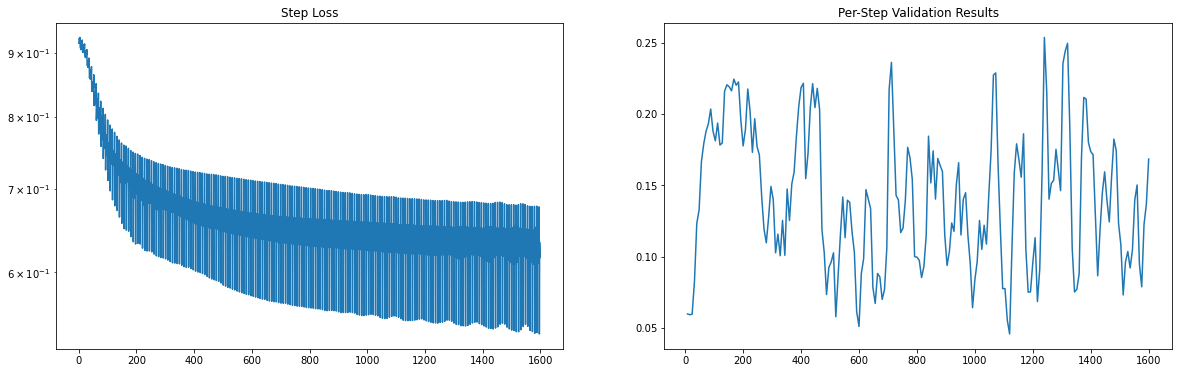

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].semilogy(*zip(*step_losses))
ax[0].set_title("Step Loss")

ax[1].plot(*zip(*epoch_metrics))
ax[1].set_title("Per-Step Validation Results")
plt.show()

Como podem ver, não estamos a obter bons resultados com a nossa rede. Os valores das perdas do treino estão a saltar e já não estão a diminuir muito. A pontuação de validação atingiu os 0,25, o que é realmente pobre. 

O próximo passo é melhorar os resultados da nossa tarefa de segmentação. As coisas a considerar para mudar incluem a própria rede, a forma como os dados são carregados, a forma como os lotes podem ser compostos e o que transformações queremos utilizar do MONAI. 